# Exploration of Sales Data

Snohomish County Parcel Search:  
https://www.snoco.org/proptax/search.aspx?parcel_number= ***PARCELHERE***


In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import combinations

from src.clean_data import clean_all_data, remove_bad_values

### Data from Mongo Database

In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [3]:
db = client['homesales_snohomish']
sales = db.homesales

In [4]:
rows = sales.find()
home_sales = pd.DataFrame(list(rows))
home_sales = home_sales.drop('_id', axis=1)

In [5]:
len(home_sales['Parcel #'].unique())

54029

### Data from csv

In [6]:
# home_sales1 = pd.read_csv(
#     'data/sales.csv',
#     index_col=0,
#     dtype={
#         'Parcel #': str,
#         'Year Built': str,
#         'Type': str,
#         'Quality/Grade': str,
#         'Address': str,
#         'City': str,
#         'Nbhd': str
#     }
# )

## Initial inspection

In [7]:
home_sales.head(2)

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code
0,31051100400500,1/31/2020 12:00:00 AM,"$2,500,000.00",5.44,,,,,21015 STATE ROUTE 9 NE,Arlington,Nbhd:5203000,521
1,00804500000100,1/31/2020 12:00:00 AM,"$416,000.00",0.29,1993,Tri Level,Avg,1430,20911 66TH AVE NE,Arlington,Nbhd:2408000,111


In [8]:
print(home_sales[:2].to_markdown())

|    |       Parcel # | Date of Sale          | Sale Price    |   Lot Size | Year Built   | Type      | Quality/Grade   | Sqft   | Address                | City      | Nbhd         |   Use Code |
|---:|---------------:|:----------------------|:--------------|-----------:|:-------------|:----------|:----------------|:-------|:-----------------------|:----------|:-------------|-----------:|
|  0 | 31051100400500 | 1/31/2020 12:00:00 AM | $2,500,000.00 |       5.44 |              |           |                 |        | 21015 STATE ROUTE 9 NE | Arlington | Nbhd:5203000 |        521 |
|  1 | 00804500000100 | 1/31/2020 12:00:00 AM | $416,000.00   |       0.29 | 1993         | Tri Level | Avg             | 1430   | 20911 66TH AVE NE      | Arlington | Nbhd:2408000 |        111 |


In [9]:
home_sales.shape

(66691, 12)

## Data Cleaning

### Filters

In [10]:
home_sales = clean_all_data(home_sales)

### Remove bad data

In [11]:
home_sales = remove_bad_values(home_sales)

In [12]:
home_sales.head()

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code
1,00804500000100,2020-01-31 12:00:00,416000.0,0.2900,1993.0,Tri Level,Avg,1430.0,20911 66TH AVE NE,Arlington,2408000,111
2,00960009607300,2020-01-31 12:00:00,75000.0,0.0000,1996.0,Dbl Wide,V Good,1620.0,20227 80TH AVE NE SPC 73,Arlington,2408906,119
3,00874800005200,2020-01-29 12:00:00,419000.0,0.1400,2001.0,1 1/2 Sty,Avg,1813.0,18127 GREYWALLS DR,Arlington,2408000,111
4,00946600000300,2020-01-29 12:00:00,347000.0,0.1166,2003.0,1 Sty,Avg-,1348.0,18722 35TH AVE NE,,2408000,111
8,00832900002300,2020-01-24 12:00:00,525000.0,0.1800,1996.0,2 Sty,Good,3055.0,7422 EAGLEFIELD DR,Arlington,2408000,111


## Looking at data

In [13]:
np.sort(home_sales['Use Code'].unique())

array([110, 111, 112, 116, 117, 118, 119, 121, 122, 123, 124, 130, 131,
       132, 133, 135, 138, 139, 141, 142, 143, 144, 145])

In [14]:
use_codes = np.load('data/use_codes.npy', allow_pickle='TRUE').item()

In [15]:
home_sales.groupby('Use Code')['Use Code'].count()

Use Code
110        3
111    30529
112        5
116     1351
117       57
118      992
119      829
121       48
122      372
123       38
124       22
130       13
131        5
132        1
133        2
135        1
138        1
139        3
141     2417
142      641
143     2900
144        1
145      653
Name: Use Code, dtype: int64

In [16]:
home_sales.groupby('Type')['Type'].count()

Type
                  12
1 1/2 Sty        929
1 1/2 Sty B      512
1 Sty          11746
1 Sty B         2258
2 Sty          15722
2 Sty B         1461
2+ Sty          1872
2+ Sty B          31
Dbl Wide        1571
Dbl Wide B         5
Multi Level        6
Quad Level         6
Sgl Wide         260
Split Entry     3137
Tri Level       1299
Trpl Wide         57
Name: Type, dtype: int64

In [17]:
# removed 112, 144 not enough values
sfr_codes = [111,113,114,115,116,118,141,142,145]

#### Create dataframe for just single family residences

In [18]:
single_family = home_sales[home_sales['Use Code'].isin(sfr_codes)].copy()

In [19]:
single_family.head(3)

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code
1,00804500000100,2020-01-31 12:00:00,416000.0,0.2900,1993.0,Tri Level,Avg,1430.0,20911 66TH AVE NE,Arlington,2408000,111
3,00874800005200,2020-01-29 12:00:00,419000.0,0.1400,2001.0,1 1/2 Sty,Avg,1813.0,18127 GREYWALLS DR,Arlington,2408000,111
4,00946600000300,2020-01-29 12:00:00,347000.0,0.1166,2003.0,1 Sty,Avg-,1348.0,18722 35TH AVE NE,,2408000,111


In [20]:
home_sales['City'].unique()

array(['Arlington', '', 'Bothell', 'Brier', 'Darrington', 'Edmonds',
       'Everett', 'Lynnwood', 'Goldbar', 'Granite Falls', 'Lake Stevens',
       'Marysville', 'Stanwood', 'Mill Creek', 'Monroe',
       'Mountlake Terrace', 'Mukilteo', 'Snohomish', 'Sultan', 'Woodway',
       'Woodinville', 'Index'], dtype=object)

## Exploration

In [21]:
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
     '#bcbd22', '#17becf']
colors = c + c

In [22]:
single_family['price/sqft'] = single_family['Sale Price']/single_family['Sqft']

In [23]:
single_family= single_family[single_family['price/sqft']<2000]

#### Look for extremes

In [24]:
single_family[single_family['Sqft'] < 200]

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code,price/sqft
25435,01049400210200,2018-10-11 12:00:00,27000.0,0.00,1997.0,1 Sty,Avg,115.0,12006 NE 204TH PL UNIT B102,,5620801,145,234.782609
26432,00556600009800,2018-10-26 12:00:00,295000.0,1.05,2005.0,Dbl Wide,Good,171.0,27103 176TH PL SE,,4120000,118,1725.146199


In [25]:
single_family.groupby('Use Code').mean()

,Sale Price,Lot Size,Year Built,Sqft,price/sqft
Use Code,,,,,
111,505816.808602,0.818805,1986.863732,2131.664931,246.758332
116,424868.384444,0.049466,2011.597037,1717.500741,249.632622
118,265067.911201,1.955308,1988.578204,1429.197275,193.544043
141,481807.489036,0.005855,2010.342987,1992.887878,244.019645
142,359489.296412,0.005348,2003.890796,1555.452418,232.178455
145,240347.569678,0.000000,1995.196018,909.166922,267.177979


In [26]:
fonts = {'fontsize':14, 'fontfamily':'serif'}

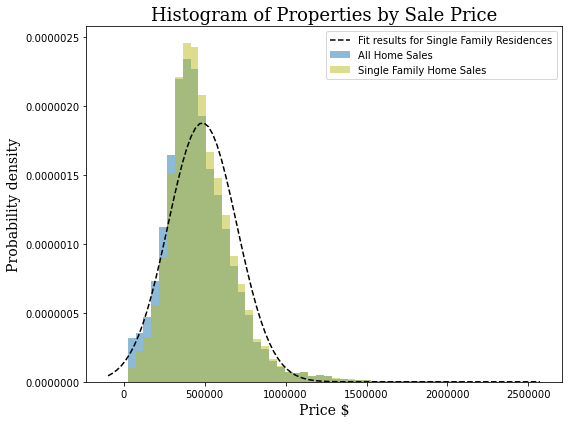

In [27]:
fig, ax = plt.subplots(figsize=(8,6))

# mu = single_family['Sale Price'].mean()
# std = single_family['Sale Price'].std()
home_sale_prices = home_sales[
    (home_sales['Sale Price'] < 2500000)]['Sale Price']
single_family_prices = single_family[
    (single_family['Sale Price'] < 2500000)]['Sale Price']

ax.hist(home_sale_prices, 
        bins=50, 
        density=True, 
        alpha=.5, 
        color=colors[0],
        label='All Home Sales')
n, bins, patches = ax.hist(single_family_prices, 
                           bins=50,
                           density=True, 
                           color=colors[8], 
                           alpha=.5, 
                           label='Single Family Home Sales')


mu, std = stats.norm.fit(single_family_prices)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k--',label = "Fit results for Single Family Residences")


# fit = stats.norm(loc=mu, scale=std).pdf(bins)
# ax.plot(bins,fit,'--')
# ax.set_xlim(0,2500000)
ax.set_xlabel('Price $', **fonts)
ax.set_ylabel('Probability density', **fonts)
ax.set_title('Histogram of Properties by Sale Price', **fonts, size=18)
ax.ticklabel_format(style='plain')
fig.tight_layout()
plt.legend()
plt.savefig('img/price_hist.png')
plt.show()

In [28]:
mean_per_day = single_family.groupby('Date of Sale')['Sale Price'].mean()

In [29]:
mean_per_day

Date of Sale
2017-01-01 12:00:00    387475.000000
2017-01-02 12:00:00    453218.750000
2017-01-03 12:00:00    435038.238095
2017-01-04 12:00:00    389594.525000
2017-01-05 12:00:00    451043.733333
                           ...      
2020-03-10 12:00:00    531000.000000
2020-03-11 12:00:00    437000.000000
2020-03-12 12:00:00    475000.000000
2020-03-16 12:00:00    353850.000000
2020-03-19 12:00:00    472500.000000
Name: Sale Price, Length: 1102, dtype: float64

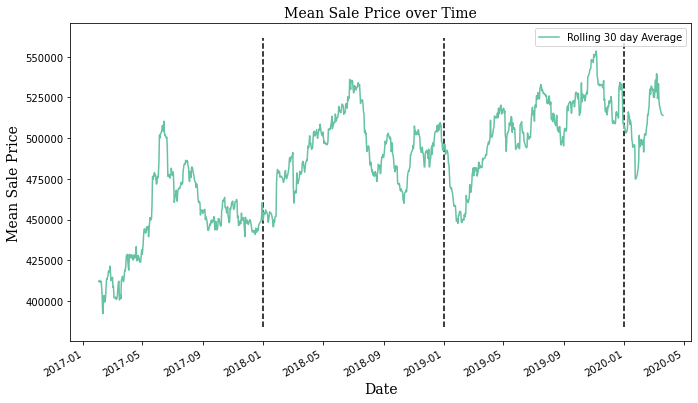

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(mean_per_day.rolling(30).mean(), color='#66c2a4', label='Rolling 30 day Average')
ymin, ymax = plt.ylim()
ax.vlines([np.datetime64('2018-01-01'),
           np.datetime64('2019-01-01'),
           np.datetime64('2020-01-01')], 
          ymin, ymax,
         linestyles='--')
ax.set_xlabel('Date', **fonts)
ax.set_ylabel('Mean Sale Price', **fonts)
ax.set_title('Mean Sale Price over Time', **fonts)
fig.tight_layout()
fig.autofmt_xdate()
plt.legend()
plt.savefig('img/mean_price_time.png')
plt.show()

In [31]:
single_family.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36580 entries, 1 to 66685
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Parcel #       36580 non-null  object        
 1   Date of Sale   36580 non-null  datetime64[ns]
 2   Sale Price     36580 non-null  float64       
 3   Lot Size       36580 non-null  float64       
 4   Year Built     36580 non-null  float64       
 5   Type           36580 non-null  object        
 6   Quality/Grade  36580 non-null  object        
 7   Sqft           36580 non-null  float64       
 8   Address        36580 non-null  object        
 9   City           36580 non-null  object        
 10  Nbhd           36580 non-null  object        
 11  Use Code       36580 non-null  int64         
 12  price/sqft     36580 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(6)
memory usage: 3.9+ MB


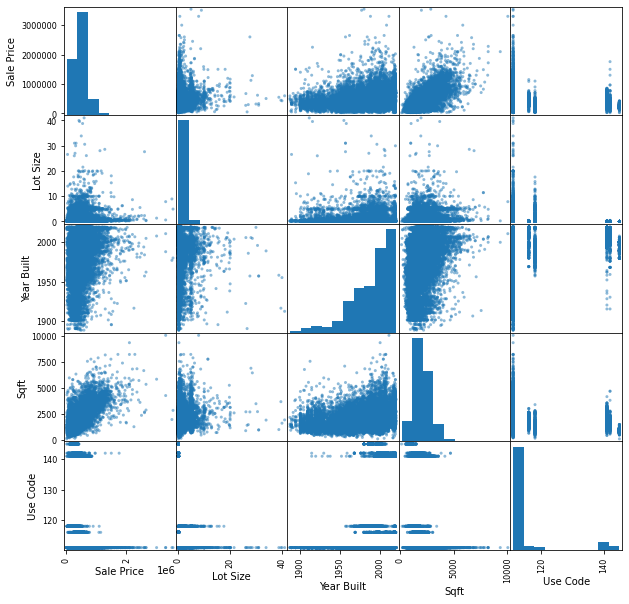

In [32]:
pd.plotting.scatter_matrix(
    single_family[
        single_family['Lot Size']<100
    ][[
        'Date of Sale', 
        'Sale Price',
        'Lot Size',
        'Year Built',
        'Type',
        'Quality/Grade',
        'Sqft',
        'Nbhd',
        'Use Code'
    ]], figsize=(10,10));

In [33]:
codes = np.sort(single_family['Use Code'].unique())

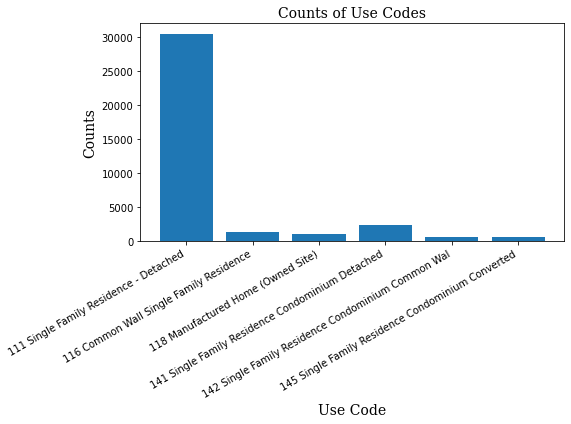

In [34]:
fig, ax = plt.subplots(figsize=(8,6))

ax.bar([use_codes[code] for code in codes], 
       single_family.groupby('Use Code')['Use Code'].value_counts())

ax.set_xlabel('Use Code', **fonts)
ax.set_ylabel('Counts', **fonts)
ax.set_title('Counts of Use Codes', **fonts)

fig.autofmt_xdate()
fig.tight_layout()
plt.savefig('img/use_code_counts.png')
plt.show()

In [35]:
sf_2019_6000sq = single_family[
    (single_family['Date of Sale']>np.datetime64('2018-12-31'))& 
    (single_family['Date of Sale']<np.datetime64('2020-01-01'))&
    (single_family['Sqft']<6000)
]

In [36]:
# single_family.info()

In [37]:
p_sqft_means = sf_2019_6000sq.groupby('Use Code')['price/sqft'].mean()
p_sqft_means

Use Code
111    260.983450
116    270.971499
118    208.503950
141    252.404748
142    244.517967
145    282.942708
Name: price/sqft, dtype: float64

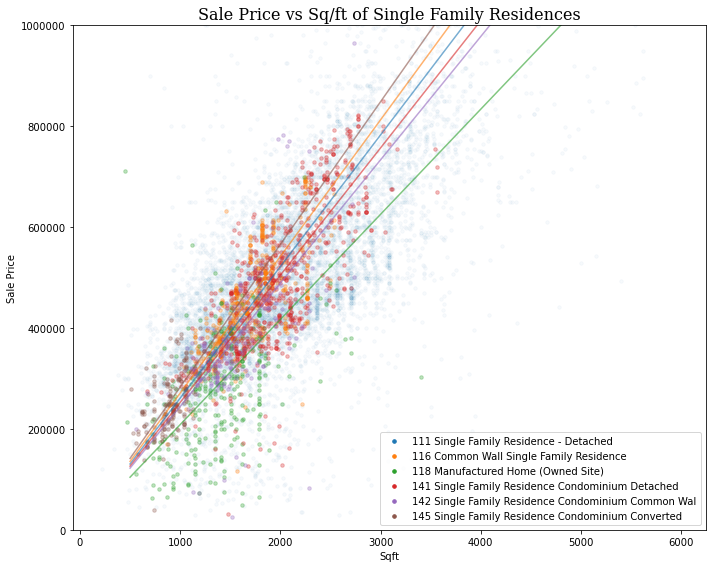

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
for i, code in enumerate(codes):
    sf_2019_6000sq[sf_2019_6000sq["Use Code"] == code].plot.scatter(
        'Sqft', 'Sale Price', 
        color=colors[i],
        marker='.',
        s=50,
        alpha=(.03 if code==111 else 0.3), ax=ax,
        label="{}".format(use_codes[code]))
    ax.plot([500,5000], np.array([500,5000])*p_sqft_means[code],color=colors[i], alpha=.6)
    
ax.set_ylim(0,1000000)
ax.set_title('Sale Price vs Sq/ft of Single Family Residences', **fonts, size=16)
ax.ticklabel_format(style='plain')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
fig.tight_layout()
plt.savefig('img/price_sqft_sfr.png')
plt.show()

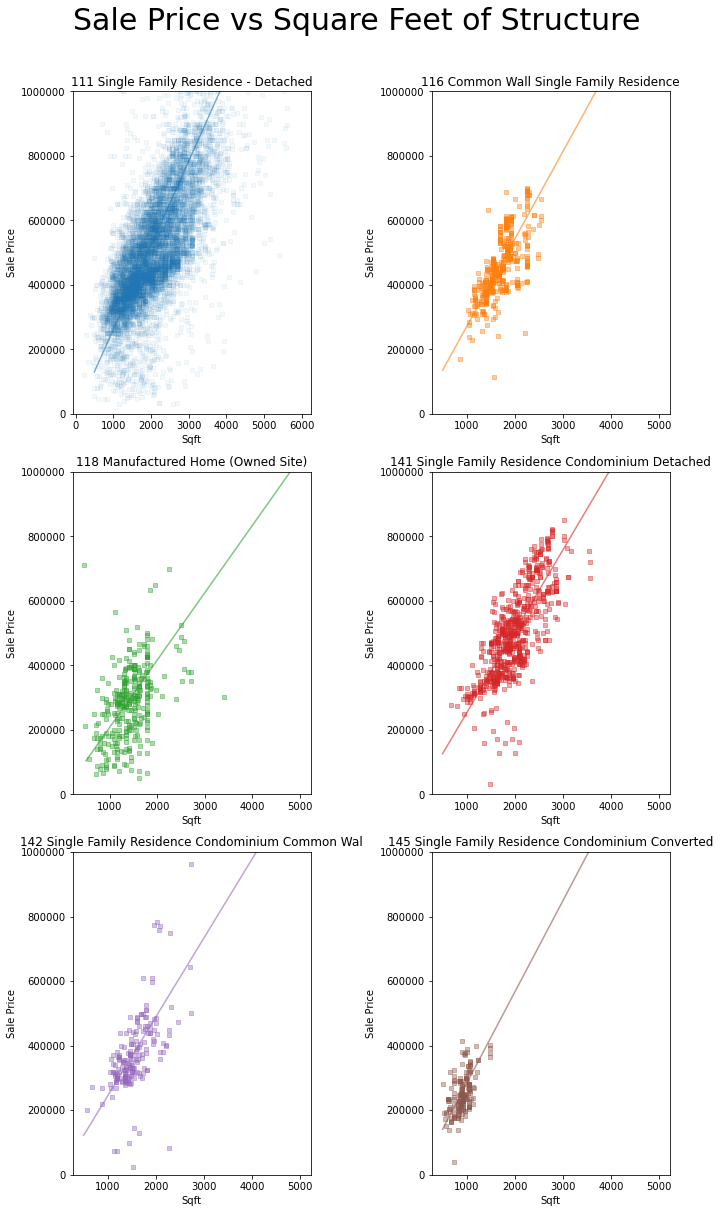

In [39]:
fig, ax1 = plt.subplots(3,2,figsize=(10,16))
axes = ax1.flatten()
for i, code in enumerate(codes):
    sf_2019_6000sq[sf_2019_6000sq["Use Code"] == code].plot.scatter(
        'Sqft', 
        'Sale Price',
        color=colors[i],
        marker=',',
        alpha=(.05 if code==111 else 0.4), 
        ax=axes[i])
    
    axes[i].plot([500,5000], np.array([500,5000])*p_sqft_means[code],
                 color=colors[i],
                 alpha=.6)
    axes[i].set_ylim(0,1000000)
    axes[i].set_title("{}".format(use_codes[code]))
    axes[i].ticklabel_format(style='plain')

fig.suptitle('Sale Price vs Square Feet of Structure',x=.5, y=1.05, size=30)
fig.tight_layout()
plt.show()

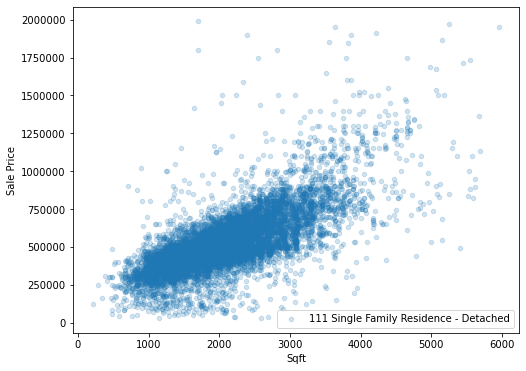

In [40]:
fig, ax = plt.subplots(figsize=(8,6))
sf_2019_6000sq[
    (sf_2019_6000sq["Use Code"] == 111) &
    (sf_2019_6000sq["Sale Price"] < 2000000)
].plot.scatter(
    'Sqft', 'Sale Price', 
    color=colors[0],
    alpha=0.2, 
    ax=ax,
    label="{}".format(use_codes[111]))
ax.ticklabel_format(style='plain');

### t-test for Use Codes

Lets find out if the price/sqft distributions are normal

In [41]:
from src.ttest_helper import plotter

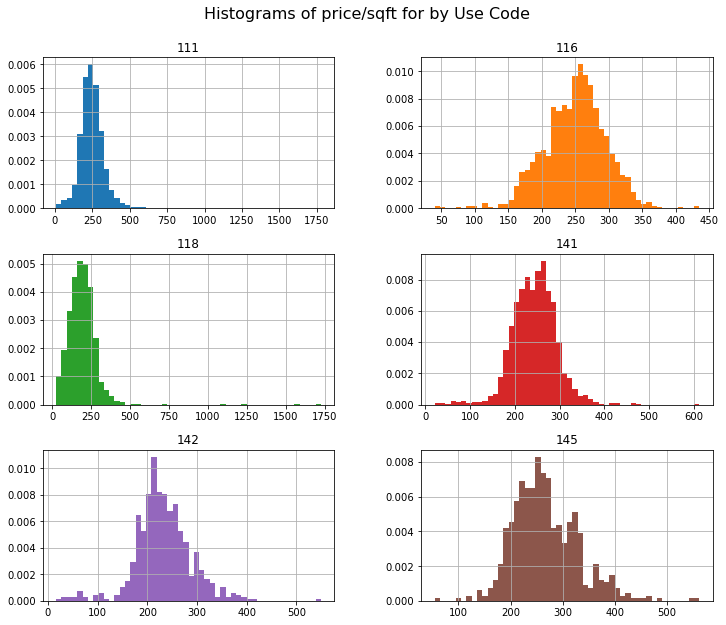

In [42]:
fig, ax = plt.subplots(3,2, figsize=(12,10))
plotter(fig, ax, single_family, 'Use Code',codes)
plt.suptitle('Histograms of price/sqft for by {}'.format('Use Code'),
            x=.5,y=.95, size=16)
# plt.savefig('img/price_sqft_sfr_hists.png')

plt.show()

We want to see if Use Code has statistical significance when comparing price per square foot.  
Because there is little risk we will set $\alpha$ at 0.1

In [43]:
single_family.groupby('Use Code')['Use Code'].value_counts()

Use Code  Use Code
111       111         30528
116       116          1350
118       118           991
141       141          2417
142       142           641
145       145           653
Name: Use Code, dtype: int64

In [44]:
codes

array([111, 116, 118, 141, 142, 145])

In [45]:
from src.ttest_helper import perform_ttest

In [46]:
perform_ttest(codes, single_family, 'Use Code', 0.1)

Statistical significance in price/sqft between Use Code
111 and 116: P value of 0.1965
111 and 118 are different with 90.0% confidence: P value of 0.0000
111 and 141: P value of 0.1020
111 and 142 are different with 90.0% confidence: P value of 0.0000
111 and 145 are different with 90.0% confidence: P value of 0.0000
116 and 118 are different with 90.0% confidence: P value of 0.0000
116 and 141 are different with 90.0% confidence: P value of 0.0005
116 and 142 are different with 90.0% confidence: P value of 0.0000
116 and 145 are different with 90.0% confidence: P value of 0.0000
118 and 141 are different with 90.0% confidence: P value of 0.0000
118 and 142 are different with 90.0% confidence: P value of 0.0000
118 and 145 are different with 90.0% confidence: P value of 0.0000
141 and 142 are different with 90.0% confidence: P value of 0.0000
141 and 145 are different with 90.0% confidence: P value of 0.0000
142 and 145 are different with 90.0% confidence: P value of 0.0000


<BarContainer object of 6 artists>

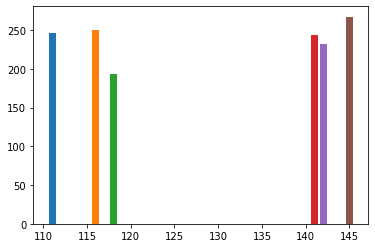

In [47]:
fig, ax = plt.subplots()
ax.bar(single_family.groupby('Use Code')['price/sqft'].mean().index,
       single_family.groupby('Use Code')['price/sqft'].mean(),
       color=colors[:6]
      )

### By type

In [48]:
types = np.sort(single_family['Type'].unique())

In [49]:
sf_types = single_family[single_family['Use Code']==111].groupby('Type').filter(lambda typ: len(typ)>50)

In [50]:
types = np.sort(sf_types['Type'].unique())

In [51]:
sf_types = sf_types[sf_types['price/sqft']<800]
sf_types.groupby('Type')['Type'].value_counts()

Type         Type       
1 1/2 Sty    1 1/2 Sty        896
1 1/2 Sty B  1 1/2 Sty B      490
1 Sty        1 Sty           8948
1 Sty B      1 Sty B         2193
2 Sty        2 Sty          12151
2 Sty B      2 Sty B         1175
2+ Sty       2+ Sty           290
Split Entry  Split Entry     3029
Tri Level    Tri Level       1282
Name: Type, dtype: int64

In [52]:
types

array(['1 1/2 Sty', '1 1/2 Sty B', '1 Sty', '1 Sty B', '2 Sty', '2 Sty B',
       '2+ Sty', 'Split Entry', 'Tri Level'], dtype=object)

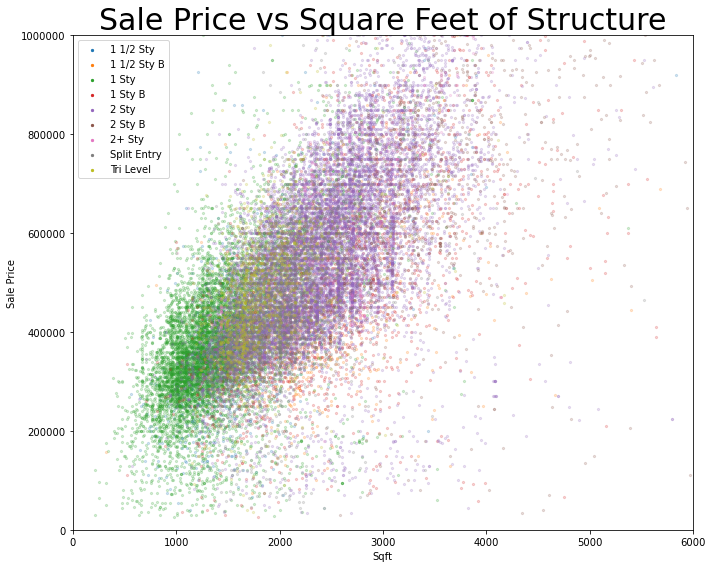

In [53]:
fig, ax = plt.subplots(figsize=(10,8))
for i, typ in enumerate(types):
    sf_types[(sf_types['Type']==typ) ].plot.scatter(
        'Sqft', 'Sale Price',
        marker='.',
        color=colors[i],
        alpha=.2, ax=ax,
        label="{}".format(typ))
ax.set_ylim(0,1000000)
ax.set_xlim(0,6000)
ax.set_title('Sale Price vs Square Feet of Structure', size=30)
ax.ticklabel_format(style='plain')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
fig.tight_layout()

In [54]:
len(types)

9

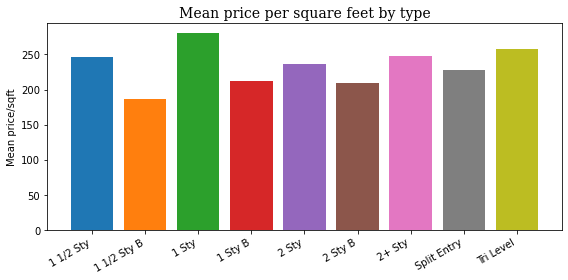

In [75]:
fig, ax = plt.subplots(figsize=(8,4))
rect = ax.bar(sf_types.groupby('Type')['price/sqft'].mean().index, 
       sf_types.groupby('Type')['price/sqft'].mean(),
      color=colors[:9])
ax.set_ylabel('Mean price/sqft')
ax.set_title('Mean price per square feet by type',**fonts)
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig('img/mean_p_sqft_type.png')
plt.show()

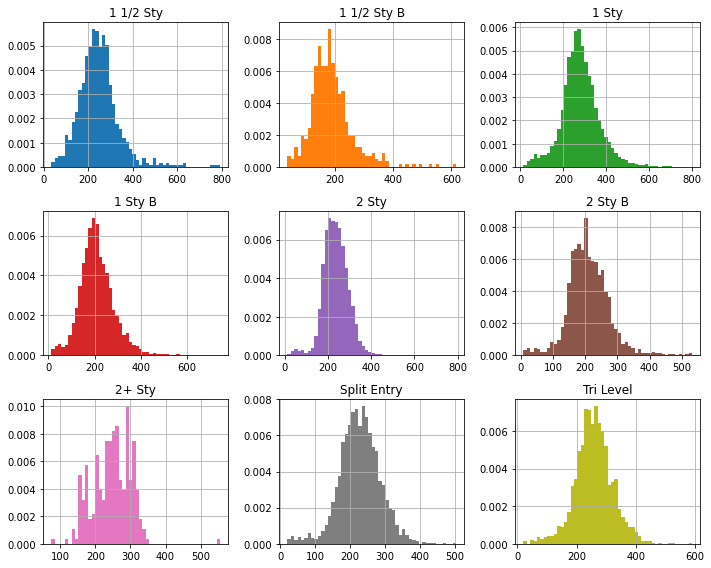

In [76]:
fig, ax = plt.subplots(3,3, figsize=(10,8))
plotter(fig, ax, sf_types, 'Type', types)
fig.tight_layout()
plt.show()

In [77]:
perform_ttest(types, sf_types, 'Type', .10)

Statistical significance in price/sqft between Type
1 1/2 Sty and 1 1/2 Sty B are different with 90.0% confidence: P value of 0.0000
1 1/2 Sty and 1 Sty are different with 90.0% confidence: P value of 0.0000
1 1/2 Sty and 1 Sty B are different with 90.0% confidence: P value of 0.0000
1 1/2 Sty and 2 Sty are different with 90.0% confidence: P value of 0.0000
1 1/2 Sty and 2 Sty B are different with 90.0% confidence: P value of 0.0000
1 1/2 Sty and 2+ Sty: P value of 0.8917
1 1/2 Sty and Split Entry are different with 90.0% confidence: P value of 0.0000
1 1/2 Sty and Tri Level are different with 90.0% confidence: P value of 0.0005
1 1/2 Sty B and 1 Sty are different with 90.0% confidence: P value of 0.0000
1 1/2 Sty B and 1 Sty B are different with 90.0% confidence: P value of 0.0000
1 1/2 Sty B and 2 Sty are different with 90.0% confidence: P value of 0.0000
1 1/2 Sty B and 2 Sty B are different with 90.0% confidence: P value of 0.0000
1 1/2 Sty B and 2+ Sty are different with 90.0% con

In [78]:
sf_types.groupby('Type')['price/sqft'].mean()

Type
1 1/2 Sty      246.515688
1 1/2 Sty B    187.178197
1 Sty          280.265700
1 Sty B        211.763840
2 Sty          236.193808
2 Sty B        209.557637
2+ Sty         247.280737
Split Entry    227.671631
Tri Level      258.093465
Name: price/sqft, dtype: float64

In [79]:
sf_types.groupby('Type')['Type'].value_counts()

Type         Type       
1 1/2 Sty    1 1/2 Sty        896
1 1/2 Sty B  1 1/2 Sty B      490
1 Sty        1 Sty           8948
1 Sty B      1 Sty B         2193
2 Sty        2 Sty          12151
2 Sty B      2 Sty B         1175
2+ Sty       2+ Sty           290
Split Entry  Split Entry     3029
Tri Level    Tri Level       1282
Name: Type, dtype: int64

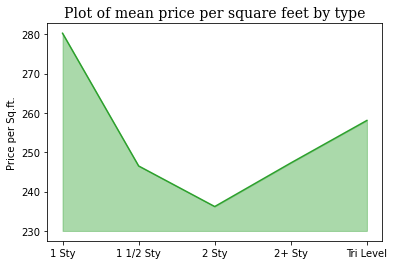

In [80]:
fig, ax = plt.subplots(figsize=(6,4))
x = ['1 Sty', '1 1/2 Sty', '2 Sty', '2+ Sty', 'Tri Level']
y = [sf_types.groupby('Type')['price/sqft'].mean()[t] for t in ['1 Sty', '1 1/2 Sty', '2 Sty', '2+ Sty', 'Tri Level']]
ax.plot(x,y,
        color = colors[2]
       )
ax.fill_between(x,y,230, color=colors[2], alpha=.4)
# ax.set_ylim(2)
ax.set_title('Plot of mean price per square feet by type', ** fonts)
ax.set_ylabel('Price per Sq.ft.')
plt.savefig('img/p_sq_type_nob.png')
plt.show()

### t-tests for Grade

In [81]:
quals = single_family.groupby('Quality/Grade')

In [82]:
qualities = ['Sub Std', 'Low', 'Fair', 'Avg-','Avg', 'Avg+', 'Good', 'V Good', 'Excellent']

In [83]:
quals['Quality/Grade'].value_counts()

Quality/Grade  Quality/Grade
Avg            Avg              17801
Avg+           Avg+              7280
Avg-           Avg-              2840
Excellent      Excellent           44
Fair           Fair              4318
Good           Good              3159
Low            Low                557
Sub Std        Sub Std             26
V Good         V Good             555
Name: Quality/Grade, dtype: int64

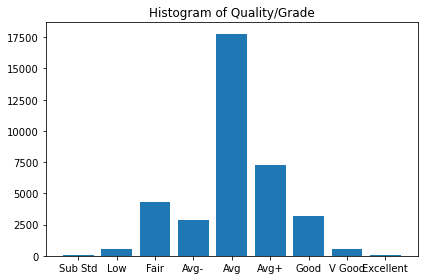

In [84]:
fig, ax = plt.subplots()

ax.bar(qualities, [len(single_family[single_family['Quality/Grade']==qual]) for qual in qualities])
ax.set_title('Histogram of Quality/Grade')
fig.tight_layout()
plt.savefig('img/quality_hist.png')
plt.show()

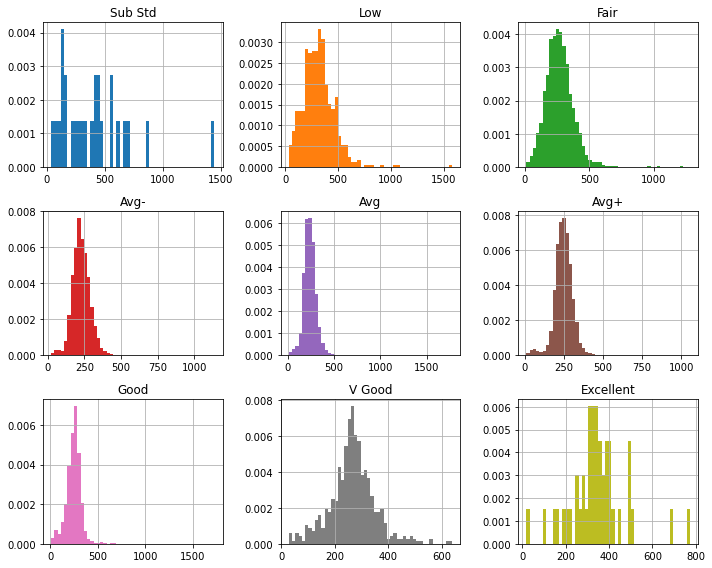

In [67]:
fig, ax1 = plt.subplots(3,3,figsize=(10,8))
plotter(fig, ax1, single_family, 'Quality/Grade',qualities)

fig.tight_layout()

In [68]:
single_family.groupby('Quality/Grade')['price/sqft'].mean()

Quality/Grade
Avg          237.308165
Avg+         248.533521
Avg-         229.577380
Excellent    343.658149
Fair         268.920620
Good         246.332532
Low          317.457129
Sub Std      396.689407
V Good       266.063057
Name: price/sqft, dtype: float64

In [69]:
 [single_family[single_family['Quality/Grade']==qual]['price/sqft'].mean() for qual in qualities]

[396.6894069687403,
 317.4571288782485,
 268.92062019773323,
 229.57738031683834,
 237.30816476266253,
 248.5335213070206,
 246.3325319151605,
 266.06305734581497,
 343.65814895653654]

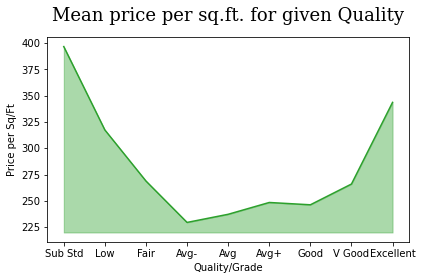

In [93]:
fig, ax = plt.subplots(figsize=(6,4))
quality_means = [single_family[single_family['Quality/Grade']==qual]['price/sqft'].mean() for qual in qualities]
ax.plot(qualities,quality_means,color=colors[2])
ax.fill_between(qualities, quality_means, 220, alpha=.4,color=colors[2])
ax.set_xlabel('Quality/Grade')
ax.set_ylabel('Price per Sq/Ft')
ax.set_title('Mean price per sq.ft. for given Quality', **fonts, size=18,y=1.05)
fig.tight_layout()
plt.savefig('img/mean_price_quality.png')
plt.show()

In [72]:
perform_ttest(qualities, single_family, 'Quality/Grade', 0.1)

Statistical significance in price/sqft between Quality/Grade
Sub Std and Low are different with 90.0% confidence: P value of 0.0152
Sub Std and Fair are different with 90.0% confidence: P value of 0.0000
Sub Std and Avg- are different with 90.0% confidence: P value of 0.0000
Sub Std and Avg are different with 90.0% confidence: P value of 0.0000
Sub Std and Avg+ are different with 90.0% confidence: P value of 0.0000
Sub Std and Good are different with 90.0% confidence: P value of 0.0000
Sub Std and V Good are different with 90.0% confidence: P value of 0.0000
Sub Std and Excellent: P value of 0.3186
Low and Fair are different with 90.0% confidence: P value of 0.0000
Low and Avg- are different with 90.0% confidence: P value of 0.0000
Low and Avg are different with 90.0% confidence: P value of 0.0000
Low and Avg+ are different with 90.0% confidence: P value of 0.0000
Low and Good are different with 90.0% confidence: P value of 0.0000
Low and V Good are different with 90.0% confidence: P v

In [603]:
quality_ttests = []

In [606]:
for qual1, qual2 in combinations(qualities, 2):
    s, p = stats.ttest_ind(
        single_family[single_family['Quality/Grade']==qual1]['price/sqft'],
        single_family[single_family['Quality/Grade']==qual2]['price/sqft'])
    quality_ttests.append((qual1, qual2, s, p))

In [607]:
print('Statistical significance in price/sqft between Types of Properties:')
for qual1, qual2, s, p in quality_ttests:
    if p<.15:
        print('{} and {} are different. P value of {:.4f}'.format(qual1,qual2,p))
    else:
        print('{} and {} are the same. P value of {:.4f}'.format(qual1,qual2,p))

Statistical significance in price/sqft between Types of Properties:
Sub Std and Low are different. P value of 0.0152
Sub Std and Fair are different. P value of 0.0000
Sub Std and Avg- are different. P value of 0.0000
Sub Std and Avg are different. P value of 0.0000
Sub Std and Avg+ are different. P value of 0.0000
Sub Std and Good are different. P value of 0.0000
Sub Std and V Good are different. P value of 0.0000
Sub Std and Excellent are the same. P value of 0.3186
Low and Fair are different. P value of 0.0000
Low and Avg- are different. P value of 0.0000
Low and Avg are different. P value of 0.0000
Low and Avg+ are different. P value of 0.0000
Low and Good are different. P value of 0.0000
Low and V Good are different. P value of 0.0000
Low and Excellent are the same. P value of 0.2697
Fair and Avg- are different. P value of 0.0000
Fair and Avg are different. P value of 0.0000
Fair and Avg+ are different. P value of 0.0000
Fair and Good are different. P value of 0.0000
Fair and V Goo